In [1]:
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
import matplotlib.pyplot as plt

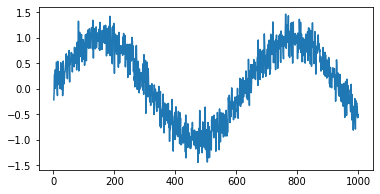

In [49]:
T = 1000
time = torch.arange(1, T+1, dtype = torch.float32)
x = torch.sin(0.01*time) + torch.normal(0, 0.2, (T,))
plt.figure(figsize=(6,3))
plt.plot(time, x.numpy())
# d2l.plot(time, [x], 'time', 'x', xlim=[1, 1000], figsize=(6, 3))

In [4]:
tau = 4 
features = torch.zeros((T-tau, tau))
for i in range(tau):
    features[:, i] = x[i:T - tau + i]
labels = x[tau:].reshape((-1,1))


In [21]:
features.shape

torch.Size([996, 4])

In [33]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dense1 = nn.Linear(4,10)
        self.dense2 = nn.Linear(10,1)
        
    def forward(self,x):
        x = nn.functional.relu(self.dense1(x))
        x = self.dense2(x)        
        return x

In [34]:
model = Net()

In [35]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [36]:
train_ds = TensorDataset(features[:600,:],labels[:600,0])
val_ds = TensorDataset(features[600:,:],labels[600:,0])

In [37]:
for x, y in train_ds:
    print(x)
    print(y)
    break

tensor([-0.4175,  0.1842, -0.3183, -0.1220])
tensor(-0.0472)


In [38]:
train_dl = DataLoader(train_ds, batch_size= 8)
val_dl = DataLoader(val_ds, batch_size=16)

In [39]:
for xb,yb in train_dl:
    print(xb.shape)
    print(yb.shape)
    break
    
for xb,yb in val_dl:
    print(xb.shape)
    print(yb.shape)
    break

torch.Size([8, 4])
torch.Size([8])
torch.Size([16, 4])
torch.Size([16])


In [40]:
def loss_batch(loss_func, output, target, opt = None):
    loss = loss_func(output, target)
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()
    return loss.item()

In [41]:
def loss_epoch(model, loss_func, dataset_dl, opt = None):
    running_loss = 0.0
    len_data = len(dataset_dl.dataset)
    
    for xb, yb in dataset_dl:
        output = model(xb)
        yb = yb.reshape((-1,1))
        loss_b = loss_batch(loss_func, output, yb, opt)
        running_loss += loss_b
    loss = running_loss/float(len_data)
    
    return loss

In [42]:
def train_val(model, loss_func, opt, train_dl, val_dl, epochs):
    loss_history={"train": [],"val": [],}
    for epoch in range(epochs):
        model.train()
        train_loss = loss_epoch(model, loss_func, train_dl, opt)
        loss_history["train"].append(train_loss)
        
        model.eval()
        with torch.no_grad():
            val_loss = loss_epoch(model, loss_func, val_dl, opt = None)
            loss_history["val"].append(val_loss)
            
        print(f"Epoch: {epoch+1}/{epochs}, train_loss: {train_loss}, val_loss: {val_loss}")
        
        
    return loss_history
            
    
    

In [43]:
loss_func = nn.MSELoss()
opt = torch.optim.Adam(model.parameters())

In [44]:
loss_dict = train_val(model, loss_func, opt, train_dl,val_dl, 20)

Epoch: 1/20, train_loss: 0.10601102319390823, val_loss: 0.02994554058055986
Epoch: 2/20, train_loss: 0.058176608028200766, val_loss: 0.015730996964254763
Epoch: 3/20, train_loss: 0.027305222653473418, val_loss: 0.0075475387886693385
Epoch: 4/20, train_loss: 0.012091313370813926, val_loss: 0.004225280855528333
Epoch: 5/20, train_loss: 0.007460102359764278, val_loss: 0.0034624732409914336
Epoch: 6/20, train_loss: 0.006616558562964201, val_loss: 0.003366555915110641
Epoch: 7/20, train_loss: 0.006510842428542674, val_loss: 0.0033482457934455438
Epoch: 8/20, train_loss: 0.006487540582505365, val_loss: 0.0033358311459346854
Epoch: 9/20, train_loss: 0.00647213158197701, val_loss: 0.0033245941699303764
Epoch: 10/20, train_loss: 0.006458727808979651, val_loss: 0.0033139297362379354
Epoch: 11/20, train_loss: 0.00644612503858904, val_loss: 0.0033036907335197685
Epoch: 12/20, train_loss: 0.006433755833034714, val_loss: 0.0032935125348769654
Epoch: 13/20, train_loss: 0.006421515109638373, val_loss:

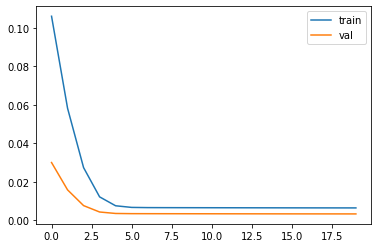

In [45]:
plt.plot(loss_dict['train'], label = 'train')
plt.plot(loss_dict['val'], label = 'val')
plt.legend()

In [46]:
onestep_preds = model(features)

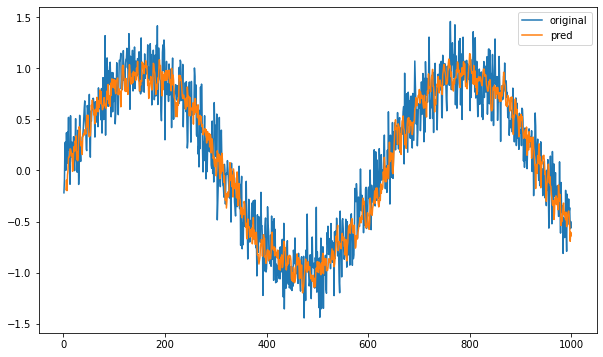

In [50]:
plt.figure(figsize=(10,6))
plt.plot(time, x.numpy(), label = 'original')
plt.plot(time[4:], onestep_preds.detach().numpy(), label = 'pred')
plt.legend()

In [51]:
n_train = 600

In [53]:
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = model(multistep_preds[i - tau:i].reshape((1, -1)))



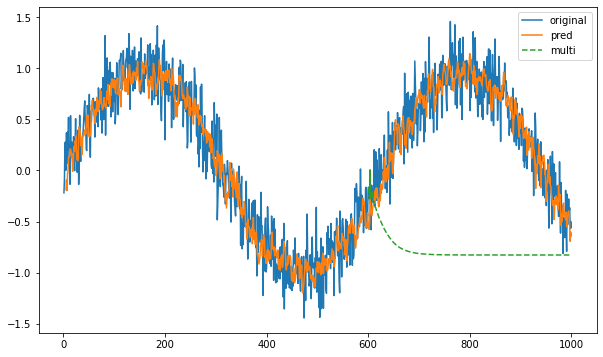

In [55]:
plt.figure(figsize=(10,6))
plt.plot(time, x.numpy(), label = 'original')
plt.plot(time[4:], onestep_preds.detach().numpy(), label = 'pred')
plt.plot(time[600:], multistep_preds.detach().numpy()[600:], label = 'multi', linestyle='dashed')

plt.legend()

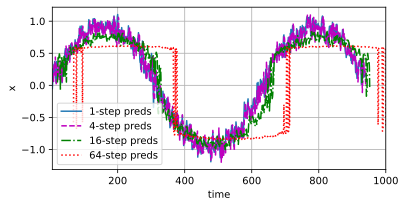

In [57]:
max_steps = 64

features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
# Column `i` (`i` < `tau`) are observations from `x` for time steps from
# `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]

# Column `i` (`i` >= `tau`) are the (`i - tau + 1`)-step-ahead predictions for
# time steps from `i + 1` to `i + T - tau - max_steps + 1`
for i in range(tau, tau + max_steps):
    features[:, i] = model(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16, 64)
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
         [features[:, (tau + i - 1)].detach().numpy() for i in steps], 'time',
         'x', legend=[f'{i}-step preds'
                      for i in steps], xlim=[5, 1000], figsize=(6, 3))
